In [ ]:
import numpy as np
import tensorflow as tf

import keras,os
#from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [ ]:
!unzip /content/drive/MyDrive/dataset/touhoufaces.zip

Streaming output truncated to the last 5000 lines.
  inflating: touhoufaces/flandre/93d34f10b99191d3f06bffc948bf2d46.png0.jpg  
  inflating: touhoufaces/flandre/93e93d8130cb120cb4c021eb6c4cb1e7.jpg0.jpg  
  inflating: touhoufaces/flandre/94530750ccc68f4d026466a467482d99.png0.jpg  
  inflating: touhoufaces/flandre/9456baa1fe284c00aa6a8927a3ea0c22.jpg0.jpg  
  inflating: touhoufaces/flandre/948f904981d36d2d42d7ba6739955a98.png1.jpg  
  inflating: touhoufaces/flandre/94d240efb978294d0b5e5599b12599ab.png0.jpg  
  inflating: touhoufaces/flandre/94f0fc77b92c91f2f9b1c93936bcbb4a.jpg0.jpg  
  inflating: touhoufaces/flandre/95e33a960557a8e9921e8eaebd61d689.png0.jpg  
  inflating: touhoufaces/flandre/9638cf89d57fb0a41e90679a5647e172.jpg0.jpg  
  inflating: touhoufaces/flandre/96456e82a063c72ebce9a92b3f6dc562.png0.jpg  
  inflating: touhoufaces/flandre/9693800cd3e0a8271a13e1962dc572f6.png0.jpg  
  inflating: touhoufaces/flandre/969bcaf0753cf44fc4460ff17474ad39.png0.jpg  
  inflating: touhoufaces/

In [ ]:
trainDir = "/content/dataset/train"
testDir = "/content/dataset/test/"
validationDir = "/content/dataset/validation/"
mainDir = "/content/touhoufaces/"
weightsPath = "/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
# Number of characters
NUM_CLASSES = 5

# Accepted image input size for ResNet50 is 224
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 9

# How many steps we take in each epoch, i.e. train BATCH_SIZE for the amount of steps
STEPS_PER_EPOCH_TRAINING = 45
STEPS_PER_EPOCH_VALIDATION = 10

# The amount of images to use in each step
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100


In [ ]:
image_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)    

traindata = image_generator.flow_from_directory(batch_size=BATCH_SIZE_TRAINING,
                                                 directory=mainDir,
                                                 shuffle=True,
                                                 target_size=(IMAGE_RESIZE, IMAGE_RESIZE), 
                                                 subset="training",
                                                 class_mode='categorical')

validationdata = image_generator.flow_from_directory(batch_size=BATCH_SIZE_VALIDATION,
                                                 directory=mainDir,
                                                 shuffle=True,
                                                 target_size=(IMAGE_RESIZE, IMAGE_RESIZE), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 4587 images belonging to 5 classes.
Found 1145 images belonging to 5 classes.


In [ ]:
#RESNET50
model = Sequential()
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE))

# 2nd layer as Dense for classification
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#RESNET50
from keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [ ]:
# Early stopping & checkpointing the best model in my google drive dir, and then using that checkpoint for later predictions
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

modelOutPath = "/content/drive/MyDrive/dataset/touhouout3.hdf5"

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = modelOutPath, monitor = 'val_loss', save_best_only = True, mode = 'auto')


In [ ]:
fit_history = model.fit_generator(
        traindata,
        epochs = NUM_EPOCHS,
        validation_data=validationdata,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights(modelOutPath)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
46/46 [==============================] - 64s 1s/step - loss: 0.7104 - accuracy: 0.7286 - val_loss: 0.4284 - val_accuracy: 0.8638
Epoch 2/50
46/46 [==============================] - 57s 1s/step - loss: 0.0432 - accuracy: 0.9875 - val_loss: 0.1302 - val_accuracy: 0.9616
Epoch 3/50
46/46 [==============================] - 57s 1s/step - loss: 0.0065 - accuracy: 0.9991 - val_loss: 0.1158 - val_accuracy: 0.9624
Epoch 4/50
46/46 [==============================] - 57s 1s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1067 - val_accuracy: 0.9624
Epoch 5/50
46/46 [==============================] - 57s 1s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0946 - val_accuracy: 0.9721
Epoch 6/50
46/46 [==============================] - 57s 1s/step - loss: 8.2416e-04 - accuracy: 1.0000 - val_loss: 0.0933 - val_accuracy: 0.9694
Epoch 7/50
46/46 [==============================] - 57s 1s/step - loss: 7.2331e-04 - accuracy: 1.0000 - val_loss: 0.0944 - val_accuracy: 0.9703
Epoch 8/50
4

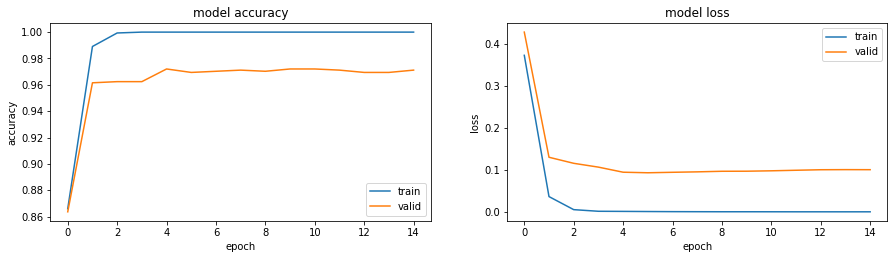

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()